# Ligand Selection and Preparation, Docking and Analysis

This notebook contains the code necessary to; prepare the ligands for docking, run docking in smina, and analyse the results of the docking.

In [2]:
# Ensure docking-env is activated as kernel.

# Import all libraries that are required.

import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdmolfiles import MolToPDBFile
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.ML.Descriptors import MoleculeDescriptors
from standardiser import standardise
import random
import string


DATAPATH = "../data"
RESULTSPATH = "../results"
SOURCEPATH = "../src"

## Ligand Standardisation

Ligand selection is done prior to this step. This can be done 1) manually, searching databased such as ChemBL, 2) via Ersilia's similarity search models, or 3) automatically via a generative model. .csv files are required, containing only an ID column (column A) and a smiles column (column B). Input files must be vetted to only contain these. If using methods 1 or 2 to provide a .csv file, the datasets can be curated manually, with empty rows, duplicate and unnecessary columns removed. ID's must only contain an integer. 

Standardisation involves converting smiles to molfiles, standardising with standardiser, converting back to smiles and remomving any smiles that are unable to be standardised.

## Ligand Filtering

Filtering is an important step to ensure only ligands that fit within specified paramters are prepared, docked an analysed. Compounds that are too small or large will not only slow the docking process, but will fall outside of the'drug-like compounds' parameters. 

Filtering involves generating descriptors of the std_smiles using RDkit. RDkit has 200 molecular descriptors. I am filtering only by molecular weight (300-800 da), but as all descriptors are generated, this step and be optimised for specific needs (e.g. constraining the number of rotatable bonds, or adhering specifically to Lipinski's rule of 5).

### Standardisaer and filterer together with no intermediate .csv files

In [49]:
# Ligand standardisation code here - smiles -> mol -> standard mol -> standard smiles

smiles_csv = os.path.join(DATAPATH, "smiles", "smallmols.csv")
filtered_std_smiles = os.path.join(DATAPATH, "smiles", "filtered_std_smallmols_vina.csv")

def prep_smiles(smiles_csv):

    df=pd.read_csv(smiles_csv) 

    mols = [Chem.MolFromSmiles(smi) for smi in df["SMILES"].tolist()]

    std_mols = []

    for mol in mols:
        if mol is not None:
            try:
                std_mol = standardise.run(mol)
            except:
                std_mol = np.nan
        else:
            std_mol = np.nan
        std_mols += [std_mol]

    std_smiles = []

    for std_mol in std_mols:
        if std_mol is not None:
            try: 
                std_smi = Chem.MolToSmiles(std_mol)
            except:
                std_smi=np.nan
        else:
            std_smi = np.nan
        std_smiles += [std_smi]

    df["ST_SMILES"] = std_smiles

    df=df[df["ST_SMILES"].notna()]

    df.drop(columns = ["SMILES"], inplace=True)

    mols = [Chem.MolFromSmiles(smi) for smi in df["ST_SMILES"].tolist()]

    mol_wts = []

    for mol in mols:
        mol_wt = Chem.Descriptors.MolWt(mol)
        mol_wts += [mol_wt]

    df["mol_wt"] = mol_wts

    df_filtered = df[df['mol_wt'] >= 300]
    df_filtered = df_filtered[df_filtered['mol_wt'] <= 800]
    df_filtered.drop(columns = ["mol_wt"], inplace=True)
    df_filtered.to_csv(filtered_std_smiles, index=False)

#prep_smiles(smiles_csv)


## Ligand Preparation

The standardised, filetered ligands are now ready for preparation. smina, a branch of AutoDock Vina, is being used as the docking software and can accept both .pdbqt or .sdf inout file format. As multiple entries can be consolidated into a single .sdf file, this is the file format we are using here. 

The process involves generating a 2D molfile from the list of std_smiles, and converting these to 3D via embedding. The choice of embdding paramters can be optimised. Certain molecules will not emded due to intrinsic molecular complexities not being compatible with RDkit's algorithm. These can be removed - we will have a long list of smiles, so removal of a small percentage of complex molecules is not a problem. These 3D molfiles are then converted to .pdb format and then to .sdf format with RDkit and openbabel, repsectively. The .sdf files are then merged together. Again, some molecules will not be written into the final merged.sdf file due to valency errors. This is not a problem. again, as we will have a long list of molecules for docking.

In [50]:
pH = 7.4
sdf_folder = os.path.join(DATAPATH, "smiles")

In [51]:
def prepare_ligands_sdf(filtered_std_smiles, pH, header_len=1, output_dir = sdf_folder, delim=',') -> list:

    out_sdfs = [] 
    
    print(filtered_std_smiles)
    
    with open(filtered_std_smiles, 'r') as csv: 
            
        for entry in csv.readlines()[header_len:]:
            
            ID, ST_SMILES = entry.split(delim)[:2]            
           
            # Convert smiles str to 3D coordinates
            mol = Chem.MolFromSmiles(ST_SMILES)
            mol = Chem.AddHs(mol)
            ps = AllChem.ETKDGv3()
            ps.useRandomCoords = True
            result = AllChem.EmbedMolecule(mol, ps)
                        
            if type(result) is int:
                if result == -1:
                    continue
           
            # Ouput coords to pdb
            pdb_name = f"{output_dir}/{ID}.pdb"
            MolToPDBFile(mol, pdb_name)
       
            # Protonate according to pH, convert to .sdf
            sdf_name = f"{output_dir}/{ID}.sdf"
            ! obabel {pdb_name} -pH {pH} -O {sdf_name} 
          
            os.remove(pdb_name) # removes the .pdb files after obabel protonates and converts to .sdf
                       
            out_sdfs.append(sdf_name)
            
    return out_sdfs

def merge_sdfs(out_sdfs, merged_sdf):

    mols = []
    for s in out_sdfs:
        suppl = Chem.SDMolSupplier(s)
        for  mol in suppl:
            if mol is None:
                continue
        else:
            mols += [mol]
        os.remove(s)

    with Chem.SDWriter(merged_sdf) as w:
        for mol in mols:
            if mol is None:
                continue
            else:
                w.write(mol)           
    

def prepare_and_merge_ligands(filtered_std_smiles,  pH, header_len=1, output_dir='', delim=','):
    ligands = prepare_ligands_sdf(filtered_std_smiles,  pH, header_len, output_dir, delim)
    merge_sdfs(ligands, output_dir+"/smallmols_vina_merged.sdf") 


#prepare_and_merge_ligands(filtered_std_smiles, pH, output_dir=sdf_folder)

In [ ]:
#This is simply a check of how many molecules are lost during embedding, conversion and writing to sdf.

suppl = Chem.SDMolSupplier('../data/validation_lists/merged.sdf')
sdfs = [x for x in suppl]
smiles = pd.read_csv('../data/validation_lists/allsimilar.csv')
filt = pd.read_csv('../data/validation_lists/filtered_std_smiles.csv')

print(f"num of std_smiles: {len(smiles)}\tnum of merged sdfs: {len(sdfs)}")

## Docking with smina

smina.static must be downloaded, at least for linux - if running on windows or similar this may be different. The receptor  must be manually prepped using AutoDock Tools. It is also a good idea to use ADT to define the grid box and make a note of the dimensions - just be sure to alter the size options to 1 angstrom. It is a good idea to include a seed - this ensures reproducibility in the results. Here, I am only using NumModes = 1, as I only want to output the top docking score for each molecule. If doing single molecules or only a small number it is a good idea to keep this at 9, as the top score may not always be the best. Do not add hydrogens here as we have already defiend the ligands with openbabel. Scoring funciton being used is vinardo - this outperforms vina in the literature and preliminary data shows that, with my datasets, it is less biased.

In [52]:
# The below is smina, run using the single .sdf file with all ligands, nconf=1. 

receptor = os.path.join(DATAPATH, "protein", "pabb_model1.pdbqt") 
ligands = os.path.join(DATAPATH, "smiles", "smallmols_vina_merged.sdf")  
log = os.path.join(RESULTSPATH, "outputs", "smallmols_vina_log.txt") 
docking_output = os.path.join(RESULTSPATH, "outputs", "smallmols_vina_outputs.sdf") 
smina = os.path.join(SOURCEPATH, "smina.static") 

docking_cmd = smina  + " -r " + receptor + " -l " + ligands + " -o " + docking_output + " --log " + log + " --seed 42 " + " --center_x 74 " + " --center_y 44 " + " --center_z 57 " + " --size_x 22 " + " --size_y 22 " + " --size_z 24 " + " --exhaustiveness 8 " + " --num_modes 1 " + " --addH off " + " --scoring vinardo "

# os.system(docking_cmd)

## Docking Analysis

Here, the output.sdf will be used to form a list of minimizedAffinity, compound ID's and std_smiles. This can be used for a number of things - for use in a generative model, or descriptors can be re-added to the final list for validation. The former is the general purpose of this project, and the latter has been done in order to form the validation.ipynb.

In [ ]:
#linking smiles and affiinity scores

affinities_id_smiles = os.path.join(RESULTSPATH, "outputs", "smallmols_vina_affinity_id_smiles.csv")


def affinities_to_smiles(docking_output):

    df = PandasTools.LoadSDF(docking_output, embedProps=True, molColName=None, smilesName='SMILES')
    df['ID'] = df['ID'].map(lambda x: x.lstrip('..data/smiles/').rstrip('.pdb'))

    df.to_csv(affinities_id_smiles, index=False)

affinities_to_smiles(affinities_id_smiles)

## Docking Validation

The code below adds the moolecular descriptors back onto the final .csv file containing the affinities, ID's and smiles strings for validation - see validation.ipynb for how these are used.

In [59]:
smiles_plus_200desc = os.path.join(RESULTSPATH, "outputs", "smallmols_vina__smiles_200descriptors.csv")                                                           

def mol_descriptor(affinities_id_smiles):
    
    mols = [Chem.MolFromSmiles(i) for i in affinities_id_smiles] 
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()
    
    Mol_descriptors =[]
    for mol in mols:
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names 


# Function call

def smiles_to_descriptors():
    
    df1 = pd.read_csv(affinities_id_smiles)
    Mol_descriptors,desc_names = mol_descriptor(df1['SMILES'])
    df_200_descriptors = pd.DataFrame(Mol_descriptors,columns=desc_names)
    merged = pd.concat([df1, df_200_descriptors], axis="columns")
    merged.to_csv(smiles_plus_200desc, index=False)

smiles_to_descriptors()


In [70]:
## Can I link the affinity/id/output file to the original .csv and have a column with 'docked?', and return NaN if not

df1 = pd.read_csv(os.path.join(DATAPATH, "smiles", "smallmols.csv"))
df2 = pd.read_csv(os.path.join(RESULTSPATH, "outputs", "affinity_id_smiles.csv"))

df_merged = pd.merge(df1, df2, on = ['ID'], how = 'outer')
df_merged.drop(columns = ["ST_SMILES"], inplace=True)

df_merged.head() 
#df_merged.to_csv(os.path.join(RESULTSPATH, "outputs", "test.csv"), index=False)


,ID,SMILES,minimizedAffinity
0,3,CN1CCC[C@H]1c1cccnc1,NaN
1,4,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,-5.46148
2,8,O=C(O)c1cn(C2CC2)c2cc(N3CCNCC3)c(F)cc2c1=O,-5.93024
3,9,CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCNCC3)cc21,-5.66769
4,12,CN1C(=O)CN=C(c2ccccc2)c2cc(Cl)ccc21,NaN


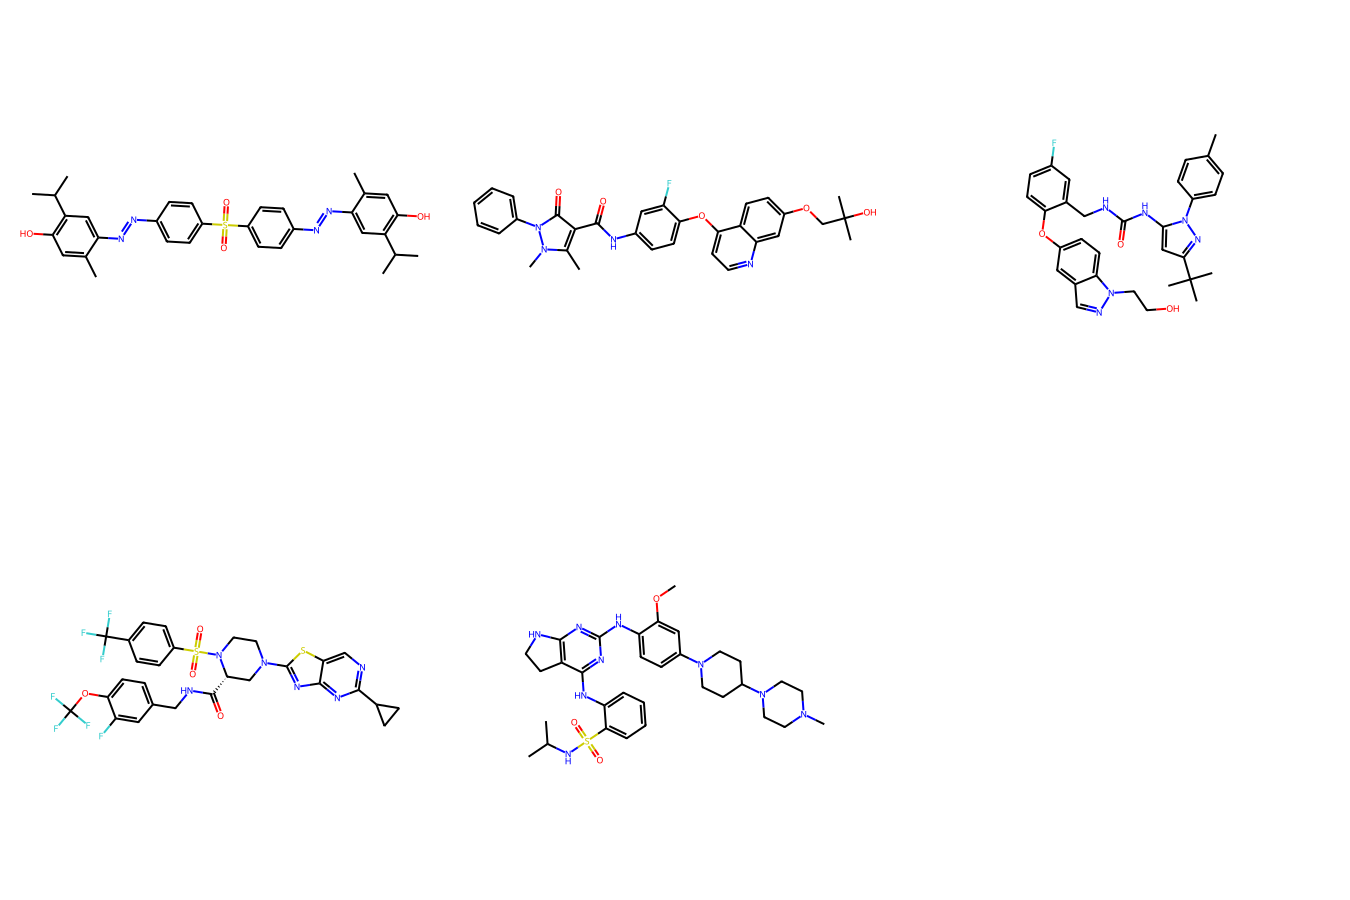

In [4]:
# Double check the lowest scoring compound manually (low scoring is better).

# The below are the top 5 binders from the cho_sim50 search - .csv output taken and 

a = Chem.MolFromSmiles('Cc1cc(O)c(C(C)C)cc1N=Nc1ccc(S(=O)(=O)c2ccc(/N=N/c3cc(C(C)C)c(O)cc3C)cc2)cc1')
b = Chem.MolFromSmiles('Cc1c(C(=O)Nc2ccc(Oc3ccnc4cc(OCC(C)(C)O)ccc34)c(F)c2)c(=O)n(-c2ccccc2)n1C')
c = Chem.MolFromSmiles('Cc1ccc(-n2nc(C(C)(C)C)cc2NC(=O)NCc2cc(F)ccc2Oc2ccc3c(cnn3CCO)c2)cc1')
d = Chem.MolFromSmiles('O=C(NCc1ccc(OC(F)(F)F)c(F)c1)[C@H]1CN(c2nc3nc(C4CC4)ncc3s2)CCN1S(=O)(=O)c1ccc(C(F)(F)F)cc1')
e = Chem.MolFromSmiles('COc1cc(N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1nc2c(c(Nc3ccccc3S(=O)(=O)NC(C)C)n1)CCN2')

Draw.MolsToGridImage((a,b,c,d,e), subImgSize=(450,450))


In [54]:
def run():
    prep_smiles(smiles_csv)
    prepare_and_merge_ligands(filtered_std_smiles, pH, output_dir=sdf_folder)
    os.remove(filtered_std_smiles)
    os.system(docking_cmd)
    os.remove(ligands)
    affinities_to_smiles(docking_output)

In [ ]:
run()